import

In [1]:
import torch

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as skm

import torch.nn as nn

データの読み込み

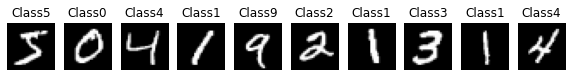

In [24]:
D = 28*28 # データの次元数
K = 10    # クラス数

# 学習データのインスタンス
dsL = MNIST(root='data', train=True, transform = ToTensor(), download = True)
dlL = DataLoader(dsL, batch_size=100, shuffle=True) # バッチ数100 シャッフル
# テストデータのインスタンス
dsT = MNIST(root='data', train=False, transform = ToTensor(), download = True)
dlT = DataLoader(dsT, batch_size=100, shuffle=True)

# 最初の10個のデータを表示
fig = plt.figure(figsize=(10, 2))
for n in range(10):
    x, y = dsL[n]  # n 番目の学習データ
    fig.add_subplot(1, 10, n+1)
    plt.title(f'Class{y}')
    plt.axis('off')
    plt.imshow(x.squeeze(), cmap='gray')
plt.show()


ニューラルネットワークモデルの定義

In [7]:
class Neuralmodel(nn.Module):
    def __init__(self, D, L, K): # D:入力の次元 L:中間層の出力数 K:出力クラス数
        super(Neuralmodel, self).__init__() # 初期化

        self.D = D
        self.K = K
        self.L = L

        # 全結合層
        self.fc = nn.Sequential(
            nn.Linear(D, L),
            nn.ReLU(), # 活性化関数
            nn.Linear(L,K)
        )

        self.logsoftmax = nn.LogSoftmax(dim=1) # ソフトマックス関数

    # 出力計算
    def forward(self, X):
        X = self.fc(X)
        X = self.logsoftmax(X)
        return X

学習(epoch 100まで10ずつ増加)

In [8]:
nepoch = 30
N = nepoch//10
model = [] # モデル保存用
loss_func = nn.NLLLoss(reduction='sum') # 交差エントロピー
optimizer = [] # 最適化器保存用
data = []

for i in range(N):
    model.append(Neuralmodel(D, 256, K).to('cpu')) # モデル作成
    optimizer.append(torch.optim.Adam(model[i].parameters())) # 最適化器の作成
    data.append([])

for k in range(10, nepoch+1, 10): 
    kn = k // 10 - 1
    for t in range(k):
        loss_sum = 0.0
        n = 0

        for X , lab in dlL:
            X = X.reshape((-1,D))

            Y = model[kn](X)
            loss = loss_func(Y, lab)

            optimizer[kn].zero_grad()
            loss.backward()
            optimizer[kn].step()

            n += len(X)
            loss_sum += loss.item()
        data[kn].append(loss_sum/n)
        # print(t, loss_sum/n)
    print("Epochs {}".format(len(data[kn])))

    

Epochs 10
Epochs 20
Epochs 30


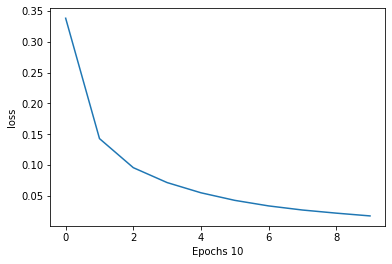

In [9]:
plt.plot(range(len(data[0])), data[0])
plt.xlabel("Epochs {}".format(len(data[0])))
plt.ylabel("loss")
plt.show()

データ格納用

In [10]:
# 学習データ用
predata = [] # 予測ラベル
labdata = [] # 正解ラベル
# テストデータ用
predataT = [] # 予測ラベル
labdataT = [] # 正解ラベル
for i in range(N):
    model[i].eval()
    predata.append([])
    predataT.append([])
    labdata.append([])
    labdataT.append([])

In [11]:
for m in range(N):
    loss_sum = 0.0
    ncorrect = 0
    n = 0
    for X, lab in dlL:
        X = X.reshape((-1,D))

        Y = model[m](X)
        loss = loss_func(Y, lab)

        n += len(X)
        loss_sum += loss.item()
        ncorrect += (Y.argmax(dim=1) == lab).sum().item()
        # data.append(lab[Y.argmax(dim=1) != lab])
        predata[m].append(Y.argmax(dim=1))
        labdata[m].append(lab)
    print(f'{(m+1)*10}epoch #L: {loss_sum/n:.4f} {ncorrect/n:.4f}')

10epoch #L: 0.0136 0.9971
20epoch #L: 0.0048 0.9987
30epoch #L: 0.0003 1.0000


In [13]:
for m in range(N):
    loss_sum = 0.0
    ncorrect = 0
    n = 0
    for X, lab in dlT:
        X = X.reshape((-1,D))

        Y = model[m](X)
        loss = loss_func(Y, lab)

        n += len(X)
        loss_sum += loss.item()
        ncorrect += (Y.argmax(dim=1) == lab).sum().item()
        # data.append(lab[Y.argmax(dim=1) != lab])
        predataT[m].append(Y.argmax(dim=1))
        labdataT[m].append(lab)
    print(f'{(m+1)*10}epoch #T: {loss_sum/n:.4f} {ncorrect/n:.4f}')

10epoch #T: 0.0637 0.9802
20epoch #T: 0.0812 0.9795
30epoch #T: 0.0856 0.9817


In [14]:
# tensorをnumpyにして混同行列を計算
Predata = []
Labdata = []
PredataT = []
LabdataT = []
for l in range(N):
    Predata.append(np.empty(0))
    Labdata.append(np.empty(0))
    PredataT.append(np.empty(0))
    LabdataT.append(np.empty(0))
for l in range(N):    
    for i in predata[l]:
        Predata[l] = np.hstack([Predata[l],i.numpy()])
    for k in labdata[l]:
        Labdata[l] = np.hstack([Labdata[l],k.numpy()])
    for i in predataT[l]:
        PredataT[l] = np.hstack([PredataT[l],i.numpy()])
    for k in labdataT[l]:
        LabdataT[l] = np.hstack([LabdataT[l],k.numpy()])

# 混同行列を計算
val = []
valT = []
for i in range(N):
    val.append(skm.confusion_matrix(Labdata[i], Predata[i]))
    valT.append(skm.confusion_matrix(LabdataT[i], PredataT[i]))
    # print(f'{(i+1)*10}epoch')

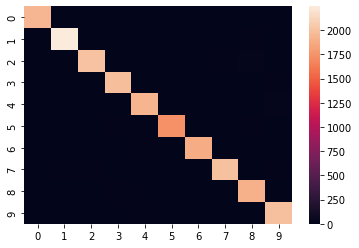

In [23]:
# 混同行列を可視化
import seaborn as sns
# sns.heatmap(val[0])
# plt.savefig('img/ex02_cmL_l256_10epoch.png')
# sns.heatmap(valT[0])
# plt.savefig('img/ex02_cmT_l256_10epoch.png')
# sns.heatmap(val[9])
# plt.savefig('img/ex02_cmL_l256_100epoch.png')
sns.heatmap(valT[0])
plt.savefig('ex02mnist_cmT_30epoch.png')

In [16]:
# テストデータの識別率最小と最大の内訳
print(valT[0]) # 識別率最小(10epoch)
print(valT[2]) # 識別率最大(60epoch)

[[1936    0    2    2    2    0    4    0    8    6]
 [   0 2246    6    2    0    2    4    0   10    0]
 [   8    8 2002    8    6    0    4   10   18    0]
 [   0    2    4 1980    0    6    0    6    6   16]
 [   2    0    2    2 1922    0    8    6    2   20]
 [   4    0    0   14    4 1736    8    0   12    6]
 [   4    6    2    2   12    8 1882    0    0    0]
 [   2   10   14    4    2    0    0 2000    8   16]
 [   2    0    2   12    8    2    4    4 1910    4]
 [   0    6    0    2   10    4    0    2    4 1990]]
[[1940    2    0    2    2    2    4    2    4    2]
 [   0 2258    2    0    0    2    4    2    2    0]
 [   6    4 2020    6    4    0    4   10    8    2]
 [   2    0    6 1984    0    6    0    8    6    8]
 [   4    0    6    0 1926    0    6    4    2   16]
 [   4    0    0   16    2 1750    2    0    4    6]
 [   8    6    4    2    4    8 1880    0    4    0]
 [   0    6   10    6    2    0    0 2016    6   10]
 [  10    0    6   18    4    6    2    6 188

# 結果と考察
テストデータに対する識別率が98%だった。内訳をみると3と8の間違いが最も多く、続いて5と4,4と9の間違いが多かった。

In [25]:
# 正解率
acc = []
for i in range(N):
    # print(f'{(i+1)*10}epoch')
    acc.append(skm.accuracy_score(LabdataT[i], PredataT[i]))

In [26]:
# 適合率
rec = []
for i in range(N):
    # print(f'{(i+1)*10}epoch')
    rec.append(skm.recall_score(LabdataT[i], PredataT[i], average=None))

In [27]:
# 再現率
pre = []
for i in range(N):
    # print(f'{(i+1)*10}epoch')
    pre.append(skm.precision_score(LabdataT[i], PredataT[i], average=None))

In [28]:
print(acc[2])
print(rec[2])
print(pre[2])

0.9817
[0.98979592 0.99471366 0.97868217 0.98217822 0.98065173 0.9809417
 0.98121086 0.98054475 0.96919918 0.97720515]
[0.98178138 0.99035088 0.98344693 0.97159647 0.98466258 0.98204265
 0.98843323 0.98054475 0.97925311 0.9743083 ]
